In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
import pickle
from food_indexing import Indexer, IndexType, BasicInvertedIndex, InvertedIndex
from food_preprocessor import RegexTokenizer, Doc2QueryAugmenter
from food_ranker import *
from relevance import *

In [2]:
recipes = pd.read_csv('recipenlg.csv')
recipes.head()

FileNotFoundError: [Errno 2] No such file or directory: 'recipenlg.csv'

In [3]:
recipes.shape

(2231142, 7)

In [3]:
# recipes['newDirections'] = ""
# recipes['newIngredients'] = ""
recipes['website'] = ''

In [4]:
count = 0
import re

for idx, row in recipes.iterrows():
    if count <= 5000000:

        Nrow = row['directions']
        ingRow = row['ingredients']
        website = row['link']
        ner = row['NER']

        pattern = r'(?:(?:https?://)?(?:www\.)?)([\w.-]+)'

        match = re.search(pattern, website)

        if match:
            domain = match.group(1)
            recipes.at[idx, 'website'] = match.group(0)
        
        pattern = r'(?<=www\.)\w+\.\w+'
        domain = re.search(pattern, website)

        # if domain:
        #     #print(domain.group(0))
        #     recipes.at[idx, 'website'] = domain.group(0)
        
        newList = Nrow[2:-2].split('"')
        secList = ingRow[2:-2].split('"')
        nerList = ner[2:-2].split('"')
        for x in secList:
            if x == ', ':
                secList.remove(x)
        for x in newList:
            if x == ', ':
                newList.remove(x)
        for x in nerList:
            if x == ', ':
                nerList.remove(x)

        recipes.at[idx, 'directions'] = " ".join(newList)
        recipes.at[idx, 'ingredients'] = secList
        recipes.at[idx, 'NER'] = nerList
        #row['directions'] = " ".join(newList)
        # set newDirections to the new list
        # try:
        #     recipes.at[idx, 'newDirections'] = " ".join(newList)
        #     recipes.at[idx, 'newIngredients'] = secList
        # except:
        #     print(newList, secList)
        #print(secList)
        #print(" ".join(newList))
        # for row in row['directions']:
        #     print(row) 
    
    else:
    
        break
    count +=1

In [7]:
recipes.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER,website
0,0,No-Bake Nut Cookies,"[1 c. firmly packed brown sugar, 1/2 c. evapor...","In a heavy 2-quart saucepan, mix brown sugar, ...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[brown sugar, milk, vanilla, nuts, butter, bit...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"[1 small jar chipped beef, cut up, 4 boned chi...",Place chipped beef on bottom of baking dish. P...,www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[beef, chicken breasts, cream of mushroom soup...",www.cookbooks.com
2,2,Creamy Corn,"[2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. c...","In a slow cooker, combine all ingredients. Cov...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[frozen corn, cream cheese, butter, garlic pow...",www.cookbooks.com
3,3,Chicken Funny,"[1 large whole chicken, 2 (10 1/2 oz.) cans ch...",Boil and debone chicken. Put bite size pieces ...,www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[chicken, chicken gravy, cream of mushroom sou...",www.cookbooks.com
4,4,Reeses Cups(Candy),"[1 c. peanut butter, 3/4 c. graham cracker cru...",Combine first four ingredients and press in 13...,www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[peanut butter, graham cracker crumbs, butter,...",www.cookbooks.com


### things to consider -> how to get individual ingredients. Just use premade NER?

In [8]:
recipes.to_csv('cleanedRecipes.csv', index=False)


In [2]:
recipes = pd.read_csv('cleanedRecipes.csv')

In [3]:
recipes.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER,website
0,0,No-Bake Nut Cookies,"['1 c. firmly packed brown sugar', '1/2 c. eva...","In a heavy 2-quart saucepan, mix brown sugar, ...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"['brown sugar', 'milk', 'vanilla', 'nuts', 'bu...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"['1 small jar chipped beef, cut up', '4 boned ...",Place chipped beef on bottom of baking dish. P...,www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"['beef', 'chicken breasts', 'cream of mushroom...",www.cookbooks.com
2,2,Creamy Corn,"['2 (16 oz.) pkg. frozen corn', '1 (8 oz.) pkg...","In a slow cooker, combine all ingredients. Cov...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"['frozen corn', 'cream cheese', 'butter', 'gar...",www.cookbooks.com
3,3,Chicken Funny,"['1 large whole chicken', '2 (10 1/2 oz.) cans...",Boil and debone chicken. Put bite size pieces ...,www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"['chicken', 'chicken gravy', 'cream of mushroo...",www.cookbooks.com
4,4,Reeses Cups(Candy),"['1 c. peanut butter', '3/4 c. graham cracker ...",Combine first four ingredients and press in 13...,www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"['peanut butter', 'graham cracker crumbs', 'bu...",www.cookbooks.com


In [5]:
recipes.iloc[0]['ingredients']  

['1 c. firmly packed brown sugar',
 '1/2 c. evaporated milk',
 '1/2 tsp. vanilla',
 '1/2 c. broken nuts (pecans)',
 '2 Tbsp. butter or margarine',
 '3 1/2 c. bite size shredded rice biscuits']

In [6]:
recipes.rename(columns={'Unnamed: 0': 'recipeID'}, inplace=True)
recipes.head()

,recipeID,title,ingredients,directions,link,source,NER,website
0,0,No-Bake Nut Cookies,"[1 c. firmly packed brown sugar, 1/2 c. evapor...","In a heavy 2-quart saucepan, mix brown sugar, ...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[brown sugar, milk, vanilla, nuts, butter, bit...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"[1 small jar chipped beef, cut up, 4 boned chi...",Place chipped beef on bottom of baking dish. P...,www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[beef, chicken breasts, cream of mushroom soup...",www.cookbooks.com
2,2,Creamy Corn,"[2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. c...","In a slow cooker, combine all ingredients. Cov...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[frozen corn, cream cheese, butter, garlic pow...",www.cookbooks.com
3,3,Chicken Funny,"[1 large whole chicken, 2 (10 1/2 oz.) cans ch...",Boil and debone chicken. Put bite size pieces ...,www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[chicken, chicken gravy, cream of mushroom sou...",www.cookbooks.com
4,4,Reeses Cups(Candy),"[1 c. peanut butter, 3/4 c. graham cracker cru...",Combine first four ingredients and press in 13...,www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[peanut butter, graham cracker crumbs, butter,...",www.cookbooks.com


In [13]:
# set recipe id type to int
recipes['recipeID'] = recipes['recipeID'].astype(int)
recipes['directions'] = recipes['directions'].astype(str)
recipes['website'] = recipes['website'].astype(str)
recipes['source'] = recipes['source'].astype(str)


In [14]:
recipes.dtypes

recipeID        int64
title          object
ingredients    object
directions     object
link           object
source         object
NER            object
website        object
dtype: object

In [7]:
with open("cleanedRecipe", "wb") as fp:   #Pickling
    pickle.dump(recipes, fp)

In [23]:
with open("cleanedRecipe", "rb") as fp:   # Unpickling
    recipes = pickle.load(fp)

In [10]:
recipes[0]

KeyError: 0

In [19]:
recipes

,Unnamed: 0,title,ingredients,directions,link,source,NER,website
0,0,No-Bake Nut Cookies,"['1 c. firmly packed brown sugar', '1/2 c. eva...","In a heavy 2-quart saucepan, mix brown sugar, ...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"['brown sugar', 'milk', 'vanilla', 'nuts', 'bu...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"['1 small jar chipped beef, cut up', '4 boned ...",Place chipped beef on bottom of baking dish. P...,www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"['beef', 'chicken breasts', 'cream of mushroom...",www.cookbooks.com
2,2,Creamy Corn,"['2 (16 oz.) pkg. frozen corn', '1 (8 oz.) pkg...","In a slow cooker, combine all ingredients. Cov...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"['frozen corn', 'cream cheese', 'butter', 'gar...",www.cookbooks.com
3,3,Chicken Funny,"['1 large whole chicken', '2 (10 1/2 oz.) cans...",Boil and debone chicken. Put bite size pieces ...,www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"['chicken', 'chicken gravy', 'cream of mushroo...",www.cookbooks.com
4,4,Reeses Cups(Candy),"['1 c. peanut butter', '3/4 c. graham cracker ...",Combine first four ingredients and press in 13...,www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"['peanut butter', 'graham cracker crumbs', 'bu...",www.cookbooks.com
...,...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,['1/2 cup chocolate hazelnut spread (recommend...,Spread hazelnut spread on 1 side of each torti...,www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"['chocolate hazelnut spread', 'tortillas', 'bu...",www.foodnetwork.com
2231138,2231138,Devil Eggs,"['1 dozen eggs', '1 paprika', '1 salt and pepp...",Boil eggs on medium for 30mins. Then cool eggs...,cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"['eggs', 'paprika', 'salt', 'choice', 'miracle...",cookpad.com
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"['150 grams Daikon radish', '1 tbsp Sesame oil...",Julienne the daikon and squeeze out the excess...,cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"['radish', 'Sesame oil', 'White sesame seeds',...",cookpad.com
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"['1 cup apple cider', '6 tablespoons sugar', '...","In a large bowl, mix the apple cider with 4 cu...",cooking.nytimes.com/recipes/1015164,Recipes1M,"['apple cider', 'sugar', 'kosher salt', 'bay l...",cooking.nytimes.com


In [20]:
recipes.to_json('cleanedRecipes.json')

In [24]:
#check dtypes of recipe colums
recipes.dtypes


Unnamed: 0      int64
title          object
ingredients    object
directions     object
link           object
source         object
NER            object
website        object
dtype: object

In [25]:
doclist = []

In [21]:
doclist = []
import json
count = 0
with open('cleanedRecipes.json') as f:
    # for line in (f):
    doclist.append(json.load(f))

  

In [23]:
doclist[0]

{'Unnamed: 0': {'0': 0,
  '1': 1,
  '2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  '6': 6,
  '7': 7,
  '8': 8,
  '9': 9,
  '10': 10,
  '11': 11,
  '12': 12,
  '13': 13,
  '14': 14,
  '15': 15,
  '16': 16,
  '17': 17,
  '18': 18,
  '19': 19,
  '20': 20,
  '21': 21,
  '22': 22,
  '23': 23,
  '24': 24,
  '25': 25,
  '26': 26,
  '27': 27,
  '28': 28,
  '29': 29,
  '30': 30,
  '31': 31,
  '32': 32,
  '33': 33,
  '34': 34,
  '35': 35,
  '36': 36,
  '37': 37,
  '38': 38,
  '39': 39,
  '40': 40,
  '41': 41,
  '42': 42,
  '43': 43,
  '44': 44,
  '45': 45,
  '46': 46,
  '47': 47,
  '48': 48,
  '49': 49,
  '50': 50,
  '51': 51,
  '52': 52,
  '53': 53,
  '54': 54,
  '55': 55,
  '56': 56,
  '57': 57,
  '58': 58,
  '59': 59,
  '60': 60,
  '61': 61,
  '62': 62,
  '63': 63,
  '64': 64,
  '65': 65,
  '66': 66,
  '67': 67,
  '68': 68,
  '69': 69,
  '70': 70,
  '71': 71,
  '72': 72,
  '73': 73,
  '74': 74,
  '75': 75,
  '76': 76,
  '77': 77,
  '78': 78,
  '79': 79,
  '80': 80,
  '81': 81,
  '82': 82,
  '83': 83

In [6]:
pd.read_json('cleanedRecipes.json')

,Unnamed: 0,title,ingredients,directions,link,source,NER,website
0,0,No-Bake Nut Cookies,"['1 c. firmly packed brown sugar', '1/2 c. eva...","In a heavy 2-quart saucepan, mix brown sugar, ...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"['brown sugar', 'milk', 'vanilla', 'nuts', 'bu...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"['1 small jar chipped beef, cut up', '4 boned ...",Place chipped beef on bottom of baking dish. P...,www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"['beef', 'chicken breasts', 'cream of mushroom...",www.cookbooks.com
2,2,Creamy Corn,"['2 (16 oz.) pkg. frozen corn', '1 (8 oz.) pkg...","In a slow cooker, combine all ingredients. Cov...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"['frozen corn', 'cream cheese', 'butter', 'gar...",www.cookbooks.com
3,3,Chicken Funny,"['1 large whole chicken', '2 (10 1/2 oz.) cans...",Boil and debone chicken. Put bite size pieces ...,www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"['chicken', 'chicken gravy', 'cream of mushroo...",www.cookbooks.com
4,4,Reeses Cups(Candy),"['1 c. peanut butter', '3/4 c. graham cracker ...",Combine first four ingredients and press in 13...,www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"['peanut butter', 'graham cracker crumbs', 'bu...",www.cookbooks.com
...,...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,['1/2 cup chocolate hazelnut spread (recommend...,Spread hazelnut spread on 1 side of each torti...,www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"['chocolate hazelnut spread', 'tortillas', 'bu...",www.foodnetwork.com
2231138,2231138,Devil Eggs,"['1 dozen eggs', '1 paprika', '1 salt and pepp...",Boil eggs on medium for 30mins. Then cool eggs...,cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"['eggs', 'paprika', 'salt', 'choice', 'miracle...",cookpad.com
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"['150 grams Daikon radish', '1 tbsp Sesame oil...",Julienne the daikon and squeeze out the excess...,cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"['radish', 'Sesame oil', 'White sesame seeds',...",cookpad.com
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"['1 cup apple cider', '6 tablespoons sugar', '...","In a large bowl, mix the apple cider with 4 cu...",cooking.nytimes.com/recipes/1015164,Recipes1M,"['apple cider', 'sugar', 'kosher salt', 'bay l...",cooking.nytimes.com


In [4]:
recipes.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER,website
0,0,No-Bake Nut Cookies,"['1 c. firmly packed brown sugar', '1/2 c. eva...","In a heavy 2-quart saucepan, mix brown sugar, ...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"['brown sugar', 'milk', 'vanilla', 'nuts', 'bu...",www.cookbooks.com
1,1,Jewell Ball'S Chicken,"['1 small jar chipped beef, cut up', '4 boned ...",Place chipped beef on bottom of baking dish. P...,www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"['beef', 'chicken breasts', 'cream of mushroom...",www.cookbooks.com
2,2,Creamy Corn,"['2 (16 oz.) pkg. frozen corn', '1 (8 oz.) pkg...","In a slow cooker, combine all ingredients. Cov...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"['frozen corn', 'cream cheese', 'butter', 'gar...",www.cookbooks.com
3,3,Chicken Funny,"['1 large whole chicken', '2 (10 1/2 oz.) cans...",Boil and debone chicken. Put bite size pieces ...,www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"['chicken', 'chicken gravy', 'cream of mushroo...",www.cookbooks.com
4,4,Reeses Cups(Candy),"['1 c. peanut butter', '3/4 c. graham cracker ...",Combine first four ingredients and press in 13...,www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"['peanut butter', 'graham cracker crumbs', 'bu...",www.cookbooks.com


In [8]:
output_file = 'cleanedRecipes.jsonl'

# Define a function to convert a DataFrame row to a JSON record
def row_to_jsonl(row):
    json_record = row.to_dict()
    json_record['NER'] = json.dumps(row['NER'])
    json_record['ingredients'] = json.dumps(row['ingredients'])
    return json.dumps(json_record)

# Write the DataFrame to a JSONL file
with open(output_file, 'w') as file:
    for index, row in recipes.iterrows():
        json_record = row_to_jsonl(row)
        file.write(json_record + '\n')

In [2]:
doclist = []
with open('cleanedRecipes.jsonl') as f:
    for line in (f):
        json_record = json.loads(line)
        json_record['ingredients'] = json.loads(json_record['ingredients'])
        json_record['NER'] = json.loads(json_record['NER'])
        doclist.append(json_record)

In [5]:
doclist[0]

{'recipeID': 0,
 'title': 'No-Bake Nut Cookies',
 'ingredients': ['1 c. firmly packed brown sugar',
  '1/2 c. evaporated milk',
  '1/2 tsp. vanilla',
  '1/2 c. broken nuts (pecans)',
  '2 Tbsp. butter or margarine',
  '3 1/2 c. bite size shredded rice biscuits'],
 'directions': 'In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.',
 'link': 'www.cookbooks.com/Recipe-Details.aspx?id=44874',
 'source': 'Gathered',
 'NER': ['brown sugar',
  'milk',
  'vanilla',
  'nuts',
  'butter',
  'bite size shredded rice biscuits'],
 'website': 'www.cookbooks.com'}

In [24]:
recipes.iloc[0]['ingredients']  

"['1 c. firmly packed brown sugar', '1/2 c. evaporated milk', '1/2 tsp. vanilla', '1/2 c. broken nuts (pecans)', '2 Tbsp. butter or margarine', '3 1/2 c. bite size shredded rice biscuits']"

In [ ]:
with open('cleanedRecipes.csv', 'r') as f:
    data = f.read()
    

In [3]:
recipes['website'].value_counts()

website
www.cookbooks.com          896341
www.food.com               499616
www.epicurious.com         129444
tastykitchen.com            78768
www.myrecipes.com           64895
www.allrecipes.com          61398
cookpad.com                 61020
cookeatshare.com            59307
www.yummly.com              51963
www.tasteofhome.com         51594
www.foodnetwork.com         49443
food52.com                  48501
www.kraftrecipes.com        42010
recipeland.com              24418
recipes-plus.com            20524
cooking.nytimes.com         16367
www.foodandwine.com         15436
www.seriouseats.com         12632
www.foodgeeks.com            8963
www.cookstr.com              8797
online-cookbook.com          5691
www.chowhound.com            5671
www.vegetariantimes.com      4578
www.delish.com               3880
allrecipes.com               3204
www.landolakes.com           2492
www.foodrepublic.com         2259
www.lovefood.com             1930
Name: count, dtype: int64

In [ ]:
recipes[recipes['source'] == 'Recipes1M']

,Unnamed: 0,title,ingredients,directions,link,source,NER,newDirections,newIngredients,website
1643098,1643098,Worlds Best Mac and Cheese,"[""6 ounces penne"", ""2 cups Beechers Flagship C...","[""Preheat the oven to 350 F. Butter or oil an ...",www.epicurious.com/recipes/food/views/-world-s...,Recipes1M,"[""penne"", ""Beechers Flagship Cheese Sauce"", ""C...",0,0,epicurious.com
1643099,1643099,Dilly Macaroni Salad Recipe,"[""1 c. elbow macaroni"", ""1 c. cubed American c...","[""Cook macaroni according to package direction...",cookeatshare.com/recipes/dilly-macaroni-salad-...,Recipes1M,"[""elbow macaroni"", ""American cheese"", ""celery""...",0,0,
1643100,1643100,Gazpacho,"[""8 tomatoes, quartered"", ""Kosher salt"", ""1 re...","[""Add the tomatoes to a food processor with a ...",www.foodnetwork.com/recipes/gazpacho1.html,Recipes1M,"[""tomatoes"", ""Kosher salt"", ""red onion"", ""gree...",0,0,foodnetwork.com
1643101,1643101,Kombu Tea Grilled Chicken Thigh,"[""2 Chicken thighs"", ""2 tsp Kombu tea"", ""1 Whi...","[""Pierce the skin of the chicken with a fork o...",cookpad.com/us/recipes/150100-kombu-tea-grille...,Recipes1M,"[""Chicken"", ""White pepper""]",0,0,
1643102,1643102,Zucchini Nut Bread,"[""2 cups flour"", ""1 tablespoon cinnamon"", ""2 t...","[""Sift dry ingredients."", ""beat eggs untill fr...",www.food.com/recipe/zucchini-nut-bread-329682,Recipes1M,"[""flour"", ""cinnamon"", ""baking soda"", ""salt"", ""...",0,0,food.com
...,...,...,...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu...",0,0,foodnetwork.com
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle...",0,0,
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",...",0,0,
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l...",0,0,


In [20]:
newList = Nrow[2:-2].split('"')

In [35]:
ingRow[2:-2].split('"')

['1 c. firmly packed brown sugar',
 ', ',
 '1/2 c. evaporated milk',
 ', ',
 '1/2 tsp. vanilla',
 ', ',
 '1/2 c. broken nuts (pecans)',
 ', ',
 '2 Tbsp. butter or margarine',
 ', ',
 '3 1/2 c. bite size shredded rice biscuits']

In [22]:
for x in newList:
    if x == ', ':
        newList.remove(x)

In [25]:
" ".join(newList)

'In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.'

## slay time

In [3]:
from importlib import reload
import food_indexing
import food_preprocessor
reload(food_indexing)
reload(food_preprocessor)
from food_indexing import Indexer, IndexType, BasicInvertedIndex, InvertedIndex
from food_preprocessor import RegexTokenizer, Doc2QueryAugmenter

In [4]:
stopwords = set()
with open('stopwords.txt', 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 610'

In [5]:
dataset_path = 'cleanedRecipes.jsonl'
# stopwords = {'and', 'the', 'or', 'is', 'for'}
text_key = 'directions'
doc_augment_dict = {}
document_preprocessor = RegexTokenizer('/w+')
minimum_word_frequency = 5

In [6]:
# setOfStopwords = {'and', 'the', 'or', 'could', 'if'}
preprocessor = RegexTokenizer('\w+', lowercase=True, multiword_expressions=None)
text_index = Indexer.create_index(IndexType.InvertedIndex, dataset_path='cleanedRecipes.jsonl', document_preprocessor=preprocessor, stopwords=stopwords, minimum_word_frequency=10, text_key='directions', max_docs=15000)
print(text_index.get_statistics())

0it [00:00, ?it/s]

2231142it [00:09, 223368.96it/s]
  1%|          | 15000/2231142 [00:00<00:23, 92463.08it/s]


Counter({'and': 35782, 'in': 20696, 'to': 13203, 'add': 12360, 'with': 10470, 'until': 10218, 'minutes': 10051, 'a': 9321, 'mix': 9090, 'for': 8865, '1': 8479, 'the': 7813, 'u00b0': 7355, 'bake': 7340, 'at': 6900, 'of': 6868, 'into': 6421, '2': 6038, 'on': 5558, 'sugar': 5275, 'ingredients': 5252, 'over': 5230, 'or': 5212, 'pour': 4765, 'pan': 4635, 'stir': 4584, 'mixture': 4566, '350': 4372, 'well': 4064, 'cook': 3940, 'cheese': 3829, 'butter': 3755, 'water': 3704, 'heat': 3587, 'salt': 3565, 'top': 3564, 'inch': 3479, 'combine': 3447, 'flour': 3422, 'together': 3353, 'cream': 3339, 'all': 3043, 'place': 2952, 'brown': 2767, 'oven': 2760, 'bowl': 2668, 'cool': 2648, 'milk': 2630, 'baking': 2573, 'beat': 2515, '4': 2482, 'x': 2479, '3': 2406, 'chicken': 2346, 'cover': 2312, 'sprinkle': 2290, 'eggs': 2282, 'onion': 2243, 'put': 2223, 'pepper': 2202, 'dish': 2196, 'large': 2098, 'about': 2095, 'then': 2094, '9': 2089, 'serve': 2054, 'cut': 2030, '10': 2029, 'greased': 1942, 'cup': 1935, 

  1%|          | 15000/2231142 [00:00<00:45, 48824.61it/s]


defaultdict(<class 'collections.Counter'>, {'index_type': 'BasicInvertedIndex', 'unique_token_count': 1518, 'total_token_count': 652926, 'number_of_documents': 15000, 'mean_document_length': 43.5284})


In [7]:
text_index.get_statistics()

defaultdict(collections.Counter,
            {'index_type': 'BasicInvertedIndex',
             'unique_token_count': 1518,
             'total_token_count': 652926,
             'number_of_documents': 15000,
             'mean_document_length': 43.5284})

In [8]:
text_index.index['cook']

[(2, 1),
 (5, 4),
 (23, 3),
 (26, 1),
 (40, 1),
 (47, 1),
 (56, 1),
 (70, 1),
 (76, 1),
 (78, 1),
 (80, 1),
 (88, 1),
 (95, 3),
 (96, 1),
 (100, 1),
 (101, 1),
 (102, 1),
 (106, 1),
 (114, 1),
 (115, 2),
 (116, 2),
 (119, 1),
 (121, 2),
 (129, 2),
 (136, 1),
 (138, 1),
 (140, 1),
 (141, 1),
 (143, 1),
 (144, 2),
 (147, 2),
 (171, 1),
 (174, 1),
 (179, 1),
 (181, 1),
 (182, 2),
 (183, 1),
 (193, 1),
 (198, 2),
 (202, 1),
 (205, 1),
 (210, 1),
 (224, 1),
 (241, 1),
 (245, 1),
 (247, 1),
 (253, 2),
 (262, 1),
 (265, 1),
 (267, 2),
 (270, 2),
 (276, 1),
 (287, 2),
 (301, 3),
 (303, 1),
 (304, 1),
 (306, 2),
 (314, 1),
 (318, 1),
 (319, 2),
 (328, 2),
 (331, 2),
 (333, 1),
 (336, 1),
 (344, 1),
 (348, 1),
 (353, 3),
 (354, 1),
 (372, 1),
 (376, 1),
 (384, 1),
 (390, 1),
 (393, 1),
 (401, 2),
 (404, 1),
 (405, 1),
 (417, 1),
 (418, 1),
 (423, 1),
 (427, 1),
 (428, 1),
 (433, 1),
 (442, 1),
 (464, 1),
 (465, 2),
 (470, 2),
 (479, 2),
 (481, 2),
 (484, 1),
 (489, 1),
 (494, 1),
 (498, 1),
 (49

In [9]:
text_index.get_postings('chicken')[:10]

[(1, 2),
 (3, 3),
 (12, 1),
 (31, 1),
 (40, 1),
 (47, 2),
 (50, 1),
 (63, 1),
 (76, 1),
 (78, 1)]

In [49]:
from food_ranker import *
import food_indexing


In [10]:
ranker = Ranker(text_index, preprocessor, stopwords, BM25)
topq = ranker.query('I want a casserole with chicken')[:10]
print(topq)

TypeError: Ranker.query() missing 2 required positional arguments: 'query_freetext' and 'query_NOT'

In [83]:
for q in topq[:10]:
    with open('cleanedRecipes.jsonl') as f:
        for line in (f):
            json_record = json.loads(line)
            if q[0] == json_record['recipeID']:
                print(json_record)
                json_record['ingredients'] = json.loads(json_record['ingredients'])
                json_record['NER'] = json.loads(json_record['NER'])
                print(json_record)
                print(json_record['ingredients'][0])
                # print(json_record['directions'])
               
                # print(json_record['title'])

    print(q)

{'recipeID': 276518, 'title': 'Spaghetti-Chicken Casserole', 'ingredients': '["1 lb. box spaghetti", "3 to 4 pkg. chicken tender strips", "2 jars spaghetti sauce", "2 (2-c.) pkg. shredded Mozzarella cheese"]', 'directions': 'Cook chicken until done; I grill mine. Cook spaghetti; drain. Layer in large casserole dish: sauce, spaghetti, chicken, sauce, then cheese. I do 2 layers, then bake 35 to 45 minutes at 350\\u00b0.', 'link': 'www.cookbooks.com/Recipe-Details.aspx?id=1023253', 'source': 'Gathered', 'NER': '["box spaghetti", "chicken tender strips", "sauce", "Mozzarella cheese"]', 'website': 'www.cookbooks.com'}
{'recipeID': 276518, 'title': 'Spaghetti-Chicken Casserole', 'ingredients': ['1 lb. box spaghetti', '3 to 4 pkg. chicken tender strips', '2 jars spaghetti sauce', '2 (2-c.) pkg. shredded Mozzarella cheese'], 'directions': 'Cook chicken until done; I grill mine. Cook spaghetti; drain. Layer in large casserole dish: sauce, spaghetti, chicken, sauce, then cheese. I do 2 layers, t

KeyboardInterrupt: 

In [62]:

ranker = Ranker(text_index, preprocessor, stopwords, BM25)
topq = ranker.query('yummy no-bake dessert')[:10]

In [26]:
topq

[(94307, 19.27803963560015),
 (86184, 17.539877645196704),
 (71707, 15.717216186522297),
 (53222, 13.728143425762184),
 (53334, 12.294039459701136),
 (53501, 11.942982747163631),
 (3272, 11.90456745941339),
 (37174, 11.263696651913738),
 (19164, 10.471378001026732),
 (85702, 10.471378001026732)]

In [27]:
for q in topq:
    print(q)

(94307, 19.27803963560015)
(86184, 17.539877645196704)
(71707, 15.717216186522297)
(53222, 13.728143425762184)
(53334, 12.294039459701136)
(53501, 11.942982747163631)
(3272, 11.90456745941339)
(37174, 11.263696651913738)
(19164, 10.471378001026732)
(85702, 10.471378001026732)


In [10]:
twentyQueries = ['I want a thanksgiving side ground beef, tomatoes, potatoes', 'a bright and crisp salad kale, oranges, sunflower seeds', 'pasta dish for a date night noodles, wine, fish, pesto, mushrooms, bread', 'fancy dinner risotto, steak, olive oil, milk, carrots, broccoli, cheese', 'something with chicken ramen, yogurt, Kool-Aid, eggs, peanut butter', 'yummy no bake dessert baking soda, baking powder, chocolate chips, eggs', 'a fun dish without meat lettuce, licorice, eggs, lemon juice, curry powder, tofu', 'desserts cinnamon, eggs, milk, ginger, butter', 'classic italian dish chicken, pasta, red sauce', 'quick asian-inspired dinner rice, tofu, hot sauce, oil', 'a unique and interesting meatloaf ground beef, cheese, ketchup, mustard, onion', 'sandwich chicken, cheese, bread, lettuce', 'chocolate, peanut butter', 'vinegar, lettuce, cracker', 'give me a pasta dish with heavy olives pasta, olives', 'popcorn, chocolate, caramel, cheese', 'salami, mayonnaise, radish', 'beets, arugula, bread, compote', 'artichoke, tomato soup, chicken', 'salmon, sriracha, rice']

In [2]:
tenQs = [ 'something with chicken ramen, yogurt, Kool-Aid, eggs, peanut butter','I want a thanksgiving side ground beef, tomatoes, potatoes', 'fancy dinner risotto, steak, olive oil, milk, carrots, broccoli, cheese', 'a fun dish without meat lettuce, licorice, eggs, lemon juice, curry powder, tofu','popcorn, chocolate, caramel, cheese','yummy no bake dessert baking soda, baking powder, chocolate chips, eggs', 'desserts cinnamon, eggs, milk, ginger, butter','give me a pasta dish with heavy olives pasta, olives','chocolate, peanut butter', 'vinegar, lettuce, cracker']
len(tenQs)

10

In [11]:
len(twentyQueries)

20

In [51]:
query2 = ['vegan flour, brown sugar', 'Fruit compote apple, oranges, honey', 'fast pasta noodles, cheese', 'mexican tortilla, tomato, lettuce', 'pie, peanut butter, whipped cream', 'green smoothie yogurt, kale, spinach', 'vegetarian stir fry tofu, rice', 'cream sauce vodka, tomato', 'taiwanese water chestnuts, carrot, dumpling', 'great dish for my kids spinach, potato, milk, sauce', 'fun potluck appetizer noodle, bean, plantains', 'arugula, steak, onion, garlic sauce', 'provide healthy dish protein', 'tilapia, capers, onion, lemon juice, wine', 'weird dessert chocolate, radish', 'greek food lamb, yogurt, pita bread', 'plum, lime, pork chop', 'crunchy salmon, tomato, couscous, granola', 'candy, diet coke, sugar, drink', 'shrimp, beef, tofu, green beans']
len(query2)

20

In [15]:
doclist = []
with open('cleanedRecipes.jsonl') as f:
    for line in (f):
        json_record = json.loads(line)
        json_record['ingredients'] = json.loads(json_record['ingredients'])
        json_record['NER'] = json.loads(json_record['NER'])
        doclist.append(json_record)

In [12]:
ranker = Ranker(text_index, preprocessor, stopwords, BM25)

In [13]:
queryDict = {}
for query in twentyQueries:
    queryDict[query] = ranker.query(query)[:40]

In [52]:
queryDict2 = {}
for query in query2:
    queryDict2[query] = ranker.query(query)[:40]

In [53]:
queryDict2

{'vegan flour, brown sugar': [(1348569, 14.443871605467708),
  (938600, 13.599526607291759),
  (1117094, 13.007562603083286),
  (1282324, 12.730898873641117),
  (1102317, 12.581029819521222),
  (1038674, 12.570971426751552),
  (1086157, 12.548705007170481),
  (947432, 12.47134744219838),
  (948009, 12.280476355069478),
  (1020336, 12.203385397544233),
  (1324932, 12.20113730816685),
  (1049477, 12.124024263428838),
  (1282888, 12.091279287596619),
  (900840, 12.054745428978377),
  (1207628, 11.940060941622136),
  (1379684, 11.926860215927462),
  (1031707, 11.923963286962262),
  (349555, 11.665563732771165),
  (897148, 11.657128251375251),
  (1129380, 11.6438631498915),
  (1292530, 11.618900761801482),
  (1230505, 11.585891185561394),
  (1121407, 11.494917809185955),
  (1231916, 11.489138730414266),
  (1371959, 11.397358374096955),
  (957252, 11.320219509081292),
  (1052394, 11.248821675549607),
  (1033869, 11.23095640086089),
  (1135557, 11.23022323778942),
  (972046, 11.22688199467287

In [14]:
queryDict

{'I want a thanksgiving side ground beef, tomatoes, potatoes': [(1076161,
   18.84293805304485),
  (1881441, 18.760436961317232),
  (1011649, 18.721583264666027),
  (1070326, 18.584237724264128),
  (1016139, 18.165358760370825),
  (955531, 18.15290017995651),
  (1806352, 18.09500127750098),
  (125701, 18.041200407381123),
  (6423, 18.018459826844598),
  (400879, 17.89192370562135),
  (491619, 17.7930904000033),
  (593319, 17.779479555694166),
  (1140121, 17.61960843913156),
  (669487, 17.60589932299317),
  (972573, 17.5690877227596),
  (836485, 17.529642238250077),
  (1278630, 17.400577896869276),
  (346145, 17.388175693787026),
  (853718, 17.350203774033027),
  (769097, 17.34857033233306),
  (1917938, 17.295137223152228),
  (440837, 17.241289646715565),
  (1370693, 17.237485376258356),
  (707233, 17.17177265207061),
  (400051, 17.110884380615598),
  (420033, 17.06557774318654),
  (343114, 17.04173797520818),
  (1131407, 17.04123475468805),
  (429868, 16.969738659143992),
  (822187, 16

In [2]:
queryDict = {'I want a thanksgiving side ground beef, tomatoes, potatoes': [(1076161,
   18.84293805304485),
  (1881441, 18.760436961317232),
  (1011649, 18.721583264666027),
  (1070326, 18.584237724264128),
  (1016139, 18.165358760370825),
  (955531, 18.15290017995651),
  (1806352, 18.09500127750098),
  (125701, 18.041200407381123),
  (6423, 18.018459826844598),
  (400879, 17.89192370562135),
  (491619, 17.7930904000033),
  (593319, 17.779479555694166),
  (1140121, 17.61960843913156),
  (669487, 17.60589932299317),
  (972573, 17.5690877227596),
  (836485, 17.529642238250077),
  (1278630, 17.400577896869276),
  (346145, 17.388175693787026),
  (853718, 17.350203774033027),
  (769097, 17.34857033233306),
  (1917938, 17.295137223152228),
  (440837, 17.241289646715565),
  (1370693, 17.237485376258356),
  (707233, 17.17177265207061),
  (400051, 17.110884380615598),
  (420033, 17.06557774318654),
  (343114, 17.04173797520818),
  (1131407, 17.04123475468805),
  (429868, 16.969738659143992),
  (822187, 16.969738659143992),
  (708833, 16.931012561111075),
  (502670, 16.829795143546225),
  (734504, 16.704889888759162),
  (1081757, 16.68665398810166),
  (166592, 16.664571422138117),
  (290189, 16.600439025198895),
  (148583, 16.547097577654323),
  (1197684, 16.544060135371097),
  (227337, 16.526371919108865),
  (1043127, 16.51041432076268)],
 'a bright and crisp salad kale, oranges, sunflower seeds': [(951328,
   29.149061508822143),
  (1281703, 28.293333141878854),
  (943265, 27.76944206107547),
  (908905, 27.27860784624936),
  (1627186, 24.832732774033204),
  (902412, 24.45783714487224),
  (948939, 24.4220869552831),
  (1329418, 24.27531442989887),
  (1046110, 24.27443041311647),
  (1285743, 24.123778065572616),
  (1284510, 23.82630456421428),
  (1863381, 23.78775878390809),
  (1396382, 23.349563502578025),
  (622251, 23.263076828956876),
  (1700419, 22.982042640975852),
  (915765, 22.93205313205631),
  (1546884, 22.722465732791527),
  (900109, 22.476899042588812),
  (1399292, 22.246205565051902),
  (1155326, 22.100387197858204),
  (1725828, 22.09290756364704),
  (1376744, 22.080365839986058),
  (1147073, 22.04204884433663),
  (1061919, 21.593940698238146),
  (392152, 21.536260031123824),
  (381078, 21.353037935768732),
  (1365588, 21.304900855668844),
  (1312605, 21.28373615350328),
  (1326569, 21.261097588301293),
  (1391543, 21.16069039512147),
  (673069, 21.13684099745855),
  (1790374, 21.12155483624648),
  (936946, 21.1086072328924),
  (1377455, 21.03169142517135),
  (927458, 20.938287604974846),
  (514190, 20.878691967013843),
  (933351, 20.826702240817298),
  (1527436, 20.763777455401982),
  (1462749, 20.62537071915936),
  (1383177, 20.620686775017937)],
 'pasta dish for a date night noodles, wine, fish, pesto, mushrooms, bread': [(1179262,
   22.25128449615408),
  (1185943, 20.79271908481493),
  (1799339, 20.611473088177416),
  (545059, 20.5078184236884),
  (955328, 20.44013314728675),
  (1068294, 20.23616098179719),
  (1868996, 19.907324282751546),
  (1383017, 19.828756868578207),
  (1035476, 19.613676792123528),
  (918639, 19.608239500747555),
  (1437585, 19.59926259196682),
  (1319927, 19.59172506654193),
  (310835, 19.583789908017),
  (1258687, 19.245866727264847),
  (1629403, 19.245866727264847),
  (650471, 19.1266375385605),
  (1444891, 19.092087009045265),
  (958806, 19.05434218457599),
  (1961006, 19.023525856973826),
  (1267918, 19.012102616783043),
  (1083499, 18.95499239479425),
  (896848, 18.88561060637093),
  (1777618, 18.867049006367544),
  (409957, 18.66060969232619),
  (414135, 18.553005342694934),
  (1318319, 18.392304157345585),
  (445442, 18.07053170205306),
  (1846247, 17.979890292569465),
  (986445, 17.97444823264901),
  (132659, 17.922626800365812),
  (1924257, 17.76896597075801),
  (402646, 17.75385652096802),
  (1292211, 17.65605300901176),
  (1613458, 17.638150306525837),
  (1270580, 17.63644271233681),
  (875625, 17.5769272433445),
  (1297557, 17.562778125264824),
  (1706247, 17.555268110603436),
  (1525061, 17.546759738277757),
  (1922717, 17.544915968436104)],
 'fancy dinner risotto, steak, olive oil, milk, carrots, broccoli, cheese': [(95611,
   21.356013383192273),
  (198819, 20.188858049605543),
  (1030319, 19.931206061225573),
  (1457511, 19.518150023041848),
  (567605, 19.243596895382076),
  (1724949, 19.16654536614976),
  (1997661, 19.160888706496202),
  (234493, 19.149046628949637),
  (833718, 18.887963220807013),
  (905488, 18.887833809435865),
  (439859, 18.738014438708788),
  (1955401, 18.516808408425746),
  (1819671, 18.498312085667962),
  (1066650, 18.41749970822991),
  (411118, 18.260421168764893),
  (1330528, 18.231004543517088),
  (1751113, 18.095483683294084),
  (1845215, 18.047579797200672),
  (1654828, 17.677241184709512),
  (1760114, 17.666993626490726),
  (1114337, 17.600075595893628),
  (264341, 17.578824652461062),
  (527300, 17.544873995446686),
  (1475450, 17.532380575156843),
  (1662686, 17.446263363981224),
  (387397, 17.303827944789745),
  (1348901, 17.231535295104514),
  (593885, 17.13568792215351),
  (14268, 17.12900587723487),
  (1068206, 17.126586331884578),
  (1854843, 17.118288751168443),
  (1965626, 17.103046260257617),
  (568342, 17.08148720347068),
  (1561414, 16.999924098543847),
  (12197, 16.988165531090637),
  (1447134, 16.978796220590286),
  (1314972, 16.863087804941948),
  (1757937, 16.851389274877643),
  (1278665, 16.842778055506336),
  (1742543, 16.839794020855614)],
 'something with chicken ramen, yogurt, Kool-Aid, eggs, peanut butter': [(414969,
   26.30103852184976),
  (1737981, 25.952436045377006),
  (448130, 25.909741570982412),
  (504537, 25.832875212307528),
  (1602, 25.475722950403828),
  (526297, 25.364410681943788),
  (75981, 25.303727004929918),
  (826690, 25.303727004929918),
  (427505, 25.193533067482004),
  (1643265, 25.144679036354358),
  (497248, 24.944830110161455),
  (81887, 24.802724762715698),
  (1639365, 24.793506868077777),
  (464478, 24.764008654032004),
  (1677906, 24.75534341839132),
  (1901817, 24.6697495131489),
  (1932700, 24.58140626532802),
  (48989, 24.451089493237014),
  (880170, 24.451089493237014),
  (234432, 24.385960009698024),
  (466426, 24.34853309577376),
  (464528, 24.246833419524748),
  (831450, 24.246833419524748),
  (643251, 24.14597977400644),
  (1768785, 24.07858269197567),
  (194630, 24.045961645864985),
  (143732, 23.84839075211476),
  (435484, 23.84839075211476),
  (459052, 23.84839075211476),
  (791988, 23.84839075211476),
  (842826, 23.84839075211476),
  (1124790, 23.84839075211476),
  (1492032, 23.786428402593224),
  (300201, 23.750817813013306),
  (626179, 23.750817813013306),
  (684820, 23.6540400374365),
  (775433, 23.6540400374365),
  (841439, 23.6540400374365),
  (1219527, 23.6540400374365),
  (27768, 23.558047744640184)],
 'yummy no bake dessert baking soda, baking powder, chocolate chips, eggs': [(1579104,
   31.87936525373187),
  (1732200, 27.667608837262826),
  (322587, 26.730622048235908),
  (730758, 26.546155579877794),
  (1114536, 26.546155579877794),
  (1174635, 26.42533356839024),
  (22561, 26.41439378442033),
  (517172, 26.392627011584526),
  (1929957, 26.353298367336485),
  (248364, 26.181317081896772),
  (369980, 26.091039430384036),
  (802573, 26.091039430384036),
  (833712, 26.07157137284641),
  (940444, 25.8810144221407),
  (789929, 25.855173670685616),
  (20962, 25.798719218538356),
  (737346, 25.74499992335956),
  (778227, 25.656861600943692),
  (496224, 25.651840143617438),
  (588950, 25.592566247131433),
  (813594, 25.510742321089914),
  (818528, 25.50883003143077),
  (1305846, 25.50883003143077),
  (499851, 25.367464631657413),
  (1807074, 25.367464631657413),
  (504944, 25.32188048845272),
  (1028777, 25.318535250741313),
  (88355, 25.227714957730505),
  (374364, 25.227714957730505),
  (498591, 25.227714957730505),
  (559882, 25.227714957730505),
  (172553, 25.227579405103256),
  (120463, 25.22684875306382),
  (1341029, 25.22684875306382),
  (873196, 25.193226195884403),
  (781966, 25.15391549036606),
  (666223, 25.141410534980142),
  (820010, 25.137010250781486),
  (1923937, 25.08969026354338),
  (224001, 25.089552713315246)],
 'a fun dish without meat lettuce, licorice, eggs, lemon juice, curry powder, tofu': [(1002014,
   22.457935338180892),
  (50097, 21.389465669991232),
  (690227, 21.144278679575688),
  (1378363, 21.079806658098104),
  (1163643, 20.67007548395562),
  (1531543, 20.51432021404972),
  (19895, 20.42077896271263),
  (318817, 20.290292093632438),
  (692531, 20.202677481361118),
  (1060285, 19.973466250489203),
  (509475, 19.956669854485565),
  (1662790, 19.94816660410414),
  (611493, 19.926771978206904),
  (485217, 19.911423034792147),
  (121437, 19.823300835927242),
  (1075757, 19.817259622577563),
  (440531, 19.654122791443424),
  (911727, 19.64243229607764),
  (1931666, 19.59236907030722),
  (1019801, 19.50211803205152),
  (185688, 19.45790983431823),
  (1111251, 19.45790983431823),
  (1662593, 19.348995022006772),
  (841453, 19.339087902535383),
  (260289, 19.31511319538847),
  (749600, 19.28033299870341),
  (988141, 19.227367661163207),
  (326756, 19.22170836181569),
  (336968, 19.20516582706904),
  (271985, 19.131996697263737),
  (529863, 19.109894808139188),
  (666248, 19.10574510661851),
  (794354, 19.10574510661851),
  (286530, 19.034893267111507),
  (937996, 18.992826247609056),
  (766819, 18.98299023580996),
  (756784, 18.877966142935378),
  (1464767, 18.865635170366737),
  (395208, 18.830801239045247),
  (835930, 18.652981100646556)],
 'desserts cinnamon, eggs, milk, ginger, butter': [(357840,
   17.054057820503186),
  (1810986, 15.909219031028275),
  (1142840, 15.567152993780088),
  (751516, 15.480381926316994),
  (24499, 15.40931920843789),
  (538540, 15.109577797363446),
  (442792, 14.826505176468565),
  (1856810, 14.63484904349231),
  (1743885, 14.620045202604443),
  (67336, 14.48650088032287),
  (333845, 14.46550653555674),
  (80121, 14.438777968276181),
  (637127, 14.394087073064105),
  (1159747, 14.26284722170434),
  (887813, 14.194013361543714),
  (1129387, 14.002379758186576),
  (829679, 13.889624973225462),
  (735509, 13.77879320399765),
  (1677191, 13.77879320399765),
  (806483, 13.730367188230751),
  (532726, 13.695162144140646),
  (722139, 13.695162144140646),
  (1671030, 13.630420684634894),
  (353170, 13.612540165240862),
  (110587, 13.590040260980913),
  (577457, 13.575305843688687),
  (591245, 13.546472802423175),
  (845029, 13.530909113668198),
  (1553576, 13.522046379013673),
  (1879414, 13.522046379013673),
  (370958, 13.505981124845125),
  (830126, 13.450251268648211),
  (1833675, 13.42990728750511),
  (374782, 13.41698364171048),
  (758715, 13.41698364171048),
  (834713, 13.41698364171048),
  (823531, 13.370549329437308),
  (458600, 13.329151375856817),
  (873081, 13.329151375856817),
  (662390, 13.291786402951189)],
 'classic italian dish chicken, pasta, red sauce': [(505505,
   21.730004430501708),
  (1758948, 21.152364926642754),
  (1973536, 20.32260213402337),
  (1200126, 20.302367269256052),
  (1606895, 20.171408090234507),
  (1653129, 19.928497514460044),
  (971051, 19.90592323660959),
  (1025856, 19.8263447625818),
  (1610172, 19.51060016110966),
  (1971732, 19.395096636704892),
  (1279239, 19.236609170261712),
  (1048093, 18.759111637375774),
  (1907543, 18.757313766777116),
  (1858341, 18.73761258718094),
  (1737710, 18.659251276900534),
  (1195412, 18.62130069549682),
  (1890477, 18.535783680876392),
  (1043054, 18.514817682842107),
  (1848809, 18.45846636754733),
  (1783515, 18.31021080167605),
  (1227724, 18.30085293201123),
  (1469846, 18.268884455594605),
  (1702252, 18.21434647961809),
  (1980906, 18.16296313621388),
  (990050, 18.14960074094883),
  (1359583, 18.140063008101098),
  (1130648, 18.055099335032775),
  (1421479, 18.011879365359302),
  (1694482, 18.001104833372896),
  (1436434, 17.948401485576568),
  (1747699, 17.84154378442688),
  (1619972, 17.812711347043045),
  (1619983, 17.78777797981597),
  (1041240, 17.721930472875087),
  (1734152, 17.682161393055267),
  (1276151, 17.671408559636504),
  (1681128, 17.65595071695941),
  (1966825, 17.64196491512472),
  (1056317, 17.61494260269187),
  (941794, 17.610548087700806)],
 'quick asian-inspired dinner rice, tofu, hot sauce, oil': [(1147967,
   23.51456690942372),
  (1471441, 23.11390842493298),
  (784845, 23.07248599278292),
  (1268057, 22.17448974816039),
  (1610575, 22.17448974816039),
  (1227082, 21.62099178790837),
  (1094618, 21.365138514143002),
  (1776070, 21.133443805786438),
  (1482207, 21.044672476162987),
  (1907551, 20.749563909038088),
  (1597779, 20.55718449068471),
  (1476490, 20.38542102540569),
  (1144471, 20.24847963557736),
  (1420948, 19.73156894577632),
  (1128789, 19.706012452349594),
  (1376537, 19.37745112201195),
  (1708213, 19.280534443977878),
  (919336, 19.210465553782722),
  (1453053, 19.182090163588153),
  (1243701, 19.172475260092718),
  (1601292, 19.11191592823393),
  (988328, 18.982750707062003),
  (1727979, 18.949283292392607),
  (974495, 18.93892895395137),
  (1121649, 18.657363889961324),
  (1894438, 18.38429619589717),
  (1205258, 18.384287392693075),
  (1347404, 18.376215769843412),
  (1083649, 18.356071193622608),
  (1455672, 18.350500873456532),
  (1400017, 18.341650529361065),
  (1934768, 18.302598544499233),
  (1947624, 18.296825190565784),
  (945398, 18.288149690488982),
  (1255981, 18.2801093081168),
  (1733110, 18.217736283874984),
  (382656, 18.210529455885194),
  (1229643, 18.204617588123657),
  (1145077, 18.200816465959733),
  (1067738, 18.105739690127898)],
 'a unique and interesting meatloaf ground beef, cheese, ketchup, mustard, onion': [(1178536,
   31.651357930281684),
  (1942202, 30.796163541928458),
  (1728388, 30.08536611175643),
  (495357, 29.740442119621267),
  (1065816, 29.045490690174553),
  (274920, 28.720310548262997),
  (1014971, 27.556211148110165),
  (998415, 27.291482561154847),
  (953973, 27.29027484227007),
  (903574, 27.22437366828572),
  (1206987, 27.04993384688059),
  (1013785, 26.948006236154445),
  (966599, 26.78385605092326),
  (1067227, 26.725277209731487),
  (1089067, 26.406371759924497),
  (1593180, 26.348800843133258),
  (1034653, 26.262491144399565),
  (1248132, 26.194016319520262),
  (1066019, 24.988087738866728),
  (920816, 24.916676997472514),
  (906453, 24.840936857748606),
  (1888777, 24.786062718048786),
  (165518, 24.73548245855601),
  (1725661, 24.66915130157465),
  (826190, 24.534629997585363),
  (1815194, 24.526709913495107),
  (1966644, 24.511317143106808),
  (899890, 24.387330468652983),
  (650942, 24.291451158010624),
  (1310682, 24.24248438807177),
  (1313416, 24.14626150594944),
  (1732508, 24.131090612483614),
  (1227415, 24.07344161883655),
  (920981, 23.988181398246073),
  (697602, 23.829759616008225),
  (1308855, 23.812201738076173),
  (1742205, 23.786158831647594),
  (1102977, 23.53217657398759),
  (830185, 23.526892949365354),
  (943524, 23.332517651588766)],
 'sandwich chicken, cheese, bread, lettuce': [(1980541, 22.466910131623248),
  (144342, 21.862693155793405),
  (1817748, 21.8124445992262),
  (1137364, 21.517350924832165),
  (1733744, 21.506557038735195),
  (570750, 21.1329041413077),
  (922060, 20.730702909861503),
  (941357, 20.70756270594251),
  (1457885, 20.634953018593826),
  (1709534, 20.354506115003353),
  (1321867, 20.24084035868066),
  (1079450, 20.087410294322105),
  (1437053, 19.978507979319524),
  (1593994, 19.851907636844704),
  (1844191, 19.8393651097405),
  (1037229, 19.82136103921434),
  (1040933, 19.703104292523317),
  (1977340, 19.534463181686803),
  (1430044, 19.52284791055387),
  (303073, 19.474081579735458),
  (1634406, 19.441207560311803),
  (1964342, 19.41726614091922),
  (903389, 19.415075489387306),
  (1658394, 19.308886846782823),
  (1775047, 19.259560408478155),
  (1142642, 19.25060731049678),
  (1734601, 19.03459024857083),
  (1725952, 18.999691614899568),
  (671293, 18.951903506996924),
  (1196766, 18.906580019901384),
  (1247221, 18.83933047454037),
  (1986887, 18.735314218447567),
  (449270, 18.724926689701526),
  (1117268, 18.716042093965374),
  (1734920, 18.709035365377357),
  (1900469, 18.686691665996285),
  (1232328, 18.68481431614908),
  (1264115, 18.661135149773877),
  (1634405, 18.642172048269433),
  (1820339, 18.6302368877298)],
 'chocolate, peanut butter': [(676693, 14.378282877717943),
  (1806160, 13.99273772742249),
  (681784, 13.851256968940069),
  (810603, 13.84042942527161),
  (709459, 13.801118419354529),
  (802148, 13.68569338458007),
  (1165231, 13.615022177293373),
  (517199, 13.564562795850236),
  (117573, 13.561320569406071),
  (1411518, 13.550696588719994),
  (1631233, 13.536753117819032),
  (375800, 13.517046456913658),
  (394441, 13.511744064712333),
  (486875, 13.511744064712333),
  (700143, 13.458479510732658),
  (1806447, 13.421923529677466),
  (662700, 13.420128808770041),
  (76587, 13.419951213236462),
  (473291, 13.38631929127413),
  (855077, 13.38631929127413),
  (474507, 13.362788373467557),
  (178091, 13.331962824295918),
  (839162, 13.320070406622829),
  (81348, 13.318156398511809),
  (1816271, 13.30967295820656),
  (456127, 13.30593596610975),
  (360815, 13.301201504164085),
  (882443, 13.293048679350306),
  (1468509, 13.287967714861002),
  (441448, 13.279039997798677),
  (1714428, 13.241103263448244),
  (595522, 13.241058294332886),
  (241423, 13.237155535412708),
  (538185, 13.208664998622194),
  (1923168, 13.188133796943223),
  (767078, 13.173815210823678),
  (1730930, 13.157403618927553),
  (515234, 13.147593441182206),
  (1810239, 13.147593441182206),
  (1892444, 13.147593441182206)],
 'vinegar, lettuce, cracker': [(1738225, 12.172860646279364),
  (662950, 12.101720233502943),
  (582068, 12.018119927093323),
  (873076, 11.774108563919011),
  (497219, 11.690918295280934),
  (721439, 11.639005302893775),
  (516501, 11.597189622972236),
  (300144, 11.549972706978792),
  (129249, 11.383078609188278),
  (486284, 11.361485339952122),
  (807320, 11.35500882537239),
  (312324, 11.321710245202272),
  (757409, 11.279769781023653),
  (364424, 11.20106796160633),
  (1821484, 11.184146272184698),
  (1947804, 11.184146272184698),
  (458059, 11.050109439661725),
  (395936, 11.020753933220558),
  (1911767, 10.991338623798264),
  (355218, 10.961333940194024),
  (1770298, 10.928994933464287),
  (793361, 10.918789034936047),
  (218734, 10.91110743155354),
  (1058047, 10.881058069195257),
  (664438, 10.855018906086492),
  (172050, 10.855018906086492),
  (189871, 10.843654004913962),
  (1661881, 10.821966402179253),
  (180328, 10.799539333288834),
  (1283542, 10.799539333288834),
  (1145264, 10.796488207060587),
  (1242584, 10.769806706458317),
  (604766, 10.755345567782562),
  (1783855, 10.755063740397532),
  (717569, 10.75319400630867),
  (740437, 10.744658279206941),
  (78876, 10.69036555843099),
  (192290, 10.69036555843099),
  (1494175, 10.69036555843099),
  (383100, 10.68530368478243)],
 'give me a pasta dish with heavy olives pasta, olives': [(1570763,
   48.412663832938605),
  (1377534, 47.54471677561384),
  (1614858, 45.81810476325728),
  (1066168, 45.57317802372256),
  (206977, 45.31149885006427),
  (1101244, 45.31149885006427),
  (331059, 45.30310841148774),
  (598837, 45.05299652155031),
  (1890276, 44.878123077174784),
  (1994718, 44.83165225222699),
  (1794197, 44.825573633727856),
  (1748590, 44.54528201482596),
  (387707, 44.295953554049206),
  (1994719, 44.295953554049206),
  (175608, 44.15320333524275),
  (1931861, 44.136700615272474),
  (1040034, 43.98494683526314),
  (1305145, 43.89407052574609),
  (1207829, 43.893996945142746),
  (27763, 43.817967831552394),
  (1764591, 43.817967831552394),
  (177271, 43.80607470005197),
  (1567333, 43.798237622148676),
  (189909, 43.565416770364706),
  (1625344, 43.565416770364706),
  (1099110, 43.556466496620686),
  (1996375, 43.52041561709005),
  (760998, 43.471775410803374),
  (358913, 43.38643509281921),
  (1845872, 43.32455194449898),
  (90072, 43.2477821842711),
  (463385, 43.23432259111373),
  (321416, 43.09240518996205),
  (1877539, 43.039293497730775),
  (1106555, 42.96684974317097),
  (101193, 42.922582848658635),
  (279959, 42.893934492433964),
  (1792937, 42.87784720389327),
  (1925445, 42.85995192168308),
  (913301, 42.78042560151005)],
 'popcorn, chocolate, caramel, cheese': [(1383715, 21.88496561746565),
  (1467054, 21.80276458446342),
  (1547800, 20.501426822518656),
  (1547760, 20.143771785501468),
  (1609268, 19.759385979813587),
  (1114333, 19.41432498211097),
  (1921022, 19.253377678428336),
  (1622428, 19.05651634665957),
  (597908, 18.732773018220776),
  (1893805, 18.644603808740843),
  (1913477, 18.608857177281696),
  (907584, 18.568240908230678),
  (1131403, 18.373376318789695),
  (19911, 18.197696058082176),
  (1973215, 18.11667168007303),
  (84270, 18.080764593276246),
  (1488154, 17.972013025427163),
  (328754, 17.959809719510744),
  (1547795, 17.90562112702499),
  (1376200, 17.874183570109444),
  (1969882, 17.839929972255742),
  (956389, 17.82340981811844),
  (1936642, 17.785853040901607),
  (1165074, 17.70585152193909),
  (1190335, 17.68918906654565),
  (1547799, 17.666561661874056),
  (1733890, 17.58080089783733),
  (1547724, 17.558211648352763),
  (1737001, 17.48429525622776),
  (934752, 17.45742430552848),
  (915941, 17.397398861644504),
  (1488705, 17.253817021921783),
  (161642, 17.239827729270214),
  (1628030, 17.22378271510985),
  (1678659, 17.174688055495153),
  (834641, 17.17099677758488),
  (448024, 17.153883037354163),
  (1917937, 17.11330469870891),
  (1234906, 17.094555121200298),
  (976472, 17.044055217402587)],
 'salami, mayonnaise, radish': [(1736359, 16.184736806085898),
  (1940403, 16.151439759405484),
  (551036, 16.08020501224889),
  (1934407, 15.670606308556051),
  (1893194, 15.291721624382514),
  (1016409, 14.955688472094952),
  (1562573, 14.891838809929332),
  (1774483, 14.86879651510515),
  (791016, 14.853780557414034),
  (1948470, 14.815921669000288),
  (1630686, 14.674941247544403),
  (430693, 14.667038025140865),
  (1876024, 14.667038025140865),
  (1242271, 14.587848089420639),
  (237930, 14.579804992865405),
  (414305, 14.576949486400512),
  (1740176, 14.556222681321795),
  (1783234, 14.556222681321795),
  (1182232, 14.480257722386021),
  (360460, 14.480257722386021),
  (147854, 14.459668402269253),
  (1193400, 14.427206269396581),
  (957073, 14.384840256559514),
  (1790728, 14.352623980868941),
  (1459025, 14.29298951081805),
  (1646241, 14.29298951081805),
  (644189, 14.270352312575934),
  (634023, 14.177541171222902),
  (732190, 14.105986622398486),
  (869588, 13.995494119464766),
  (1391863, 13.975625703851241),
  (1546067, 13.906212594082456),
  (1508029, 13.83773868552823),
  (1695536, 13.80711167417024),
  (1978681, 13.75268514862821),
  (1642984, 13.731023816757904),
  (1954583, 13.720219745145098),
  (1108150, 13.672744506547666),
  (1430097, 13.667448659581247),
  (1528622, 13.664503730648295)],
 'beets, arugula, bread, compote': [(1869101, 17.27535220791828),
  (1358515, 17.1834286235608),
  (1861036, 17.158014727148625),
  (1415024, 17.133119583219973),
  (1292100, 16.738246124529464),
  (1304848, 16.675596979938646),
  (1373428, 16.601382802278753),
  (1412119, 16.595555894903285),
  (1608217, 16.50571639994795),
  (1915878, 16.50571639994795),
  (1823624, 16.41080349380464),
  (1919808, 16.361686464700295),
  (1369361, 16.346486324736187),
  (1267947, 16.310855084679087),
  (1371566, 16.27418080865943),
  (1958315, 16.215860210699535),
  (1276219, 16.214851660931874),
  (1922670, 16.208610719445907),
  (1775080, 16.208610719445907),
  (1692819, 16.113022732364293),
  (1360667, 16.110063216836163),
  (1338254, 16.10047714350793),
  (1621058, 16.098165404850363),
  (1261097, 16.098165404850363),
  (1439147, 16.09000718711934),
  (1702281, 15.962174097605997),
  (1527085, 15.803061645254243),
  (1385825, 15.792434413849445),
  (1396658, 15.728859865916084),
  (1386624, 15.699039030535854),
  (1436369, 15.692404348001677),
  (1269872, 15.671036254997938),
  (922958, 15.615074426727245),
  (1250978, 15.615074426727245),
  (905186, 15.601330438541138),
  (1265884, 15.592848393086499),
  (1351890, 15.54647937948905),
  (1387151, 15.512589963663572),
  (1211886, 15.483954843918593),
  (1691920, 15.390212392605168)],
 'artichoke, tomato soup, chicken': [(685901, 16.63073690415407),
  (295739, 16.406191495716904),
  (1203992, 16.211890989943516),
  (1592127, 15.858481861436948),
  (738944, 15.68638493799036),
  (1055125, 15.605178331288615),
  (1463000, 15.363524349387912),
  (1062009, 15.105517347363067),
  (1308512, 14.98520318780055),
  (1437250, 14.70112382055617),
  (1185659, 14.571902536806222),
  (1075817, 14.464653649442486),
  (946012, 14.361464829377944),
  (1922363, 14.324118630740212),
  (1138627, 14.295924786534787),
  (1322959, 14.13085809810483),
  (1797228, 14.101481278647153),
  (1354544, 14.01353415879101),
  (1846665, 13.979210056143849),
  (910255, 13.941408446270284),
  (1174038, 13.79006255060012),
  (1894620, 13.775520798110122),
  (292132, 13.775159729547859),
  (1714196, 13.752776400076954),
  (502818, 13.747675169638969),
  (784615, 13.685736692654869),
  (282257, 13.648989877071074),
  (1405377, 13.603353707082686),
  (333562, 13.57186280895982),
  (1624205, 13.547177364979145),
  (1725929, 13.522499265823656),
  (1232842, 13.420731293893978),
  (1077010, 13.394668644795775),
  (1926802, 13.370244418430378),
  (1430093, 13.352670873016471),
  (1207559, 13.348718646273468),
  (373028, 13.348718646273468),
  (1161557, 13.295104956049089),
  (1427818, 13.286082359327477),
  (1436069, 13.263418600758559)],
 'salmon, sriracha, rice': [(1797727, 19.127774489640718),
  (944608, 18.01911010418575),
  (1379050, 17.681645372925267),
  (914284, 17.112182049752946),
  (1639213, 17.106131456613504),
  (1932428, 16.77753034054604),
  (1750375, 16.6193771254351),
  (1315221, 16.214116940774975),
  (1354117, 15.959522205804664),
  (1347260, 15.732823902859934),
  (1812567, 15.540313955520087),
  (1328379, 15.41563959254582),
  (945071, 15.177670943669781),
  (1989849, 14.984841145926472),
  (1556826, 14.917351873527966),
  (898010, 14.722351165664996),
  (1353719, 14.620169836948401),
  (1153828, 14.613242974478416),
  (1558183, 14.355562375335452),
  (1162687, 14.324323757090887),
  (1225758, 14.324323757090887),
  (1433786, 14.306736689918722),
  (1604300, 14.208714975588574),
  (1371056, 14.184415157433452),
  (1633286, 14.108608136904508),
  (1156934, 14.070620372960628),
  (914186, 13.963248870832217),
  (1562156, 13.888497093727299),
  (1323439, 13.780023183517347),
  (1843428, 13.756355932758044),
  (930546, 13.729614577628487),
  (906097, 13.724302521501741),
  (1359805, 13.718822785213305),
  (1623274, 13.71737256373012),
  (1723084, 13.659149540850704),
  (1604502, 13.622723585172158),
  (1314832, 13.612061676928384),
  (1603651, 13.612061676928384),
  (1657668, 13.562791932962606),
  (1169726, 13.538112001588793)]}

In [10]:
from tqdm import tqdm
import json

In [54]:
annotateDict2 = {}
with open('cleanedRecipes.jsonl') as f:
    for line in tqdm(f):
        json_record = json.loads(line)
        json_record['ingredients'] = json.loads(json_record['ingredients'])
        for key, value in queryDict2.items():
            for q in value:
                if q[0] == json_record['recipeID']:
                    if key in annotateDict2:
                        annotateDict2[key].append([json_record['recipeID'],json_record['title'], json_record['ingredients'], json_record['directions']])
                    else:
                        annotateDict2[key] = [[json_record['recipeID'],json_record['title'], json_record['ingredients'], json_record['directions']]]

2231142it [02:08, 17347.57it/s]


In [55]:
for value in annotateDict2.values():
    print(len(value))

40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40


In [56]:
import random
randomQuerys = {}
for key, value in queryDict2.items():
    qList = []
    for q in value:
        qList.append(q[0])
    # get random numbers between 0 and 2 million that are not in qList
    randomQuerys[key] = []
    for i in range(20):
        while True:
            randomNum = random.randint(0, 2000000)
            if randomNum not in qList:
                randomQuerys[key].append(randomNum)
                break

            
    


In [5]:
import random
randomQuerys = {}
for q in tenQs:
    
    # get random numbers between 0 and 2 million that are not in qList
    randomQuerys[q] = []
    for i in range(60):
        while True:
            randomNum = random.randint(0, 1500000)
            if randomNum not in randomQuerys[q]:
                randomQuerys[q].append(randomNum)
                break

In [6]:
randomQuerys

{'something with chicken ramen, yogurt, Kool-Aid, eggs, peanut butter': [1338,
  1136408,
  910271,
  531271,
  60496,
  43873,
  509078,
  1482042,
  882710,
  199918,
  247637,
  278335,
  1357736,
  1409392,
  1270785,
  433153,
  70246,
  719793,
  1140177,
  707568,
  957714,
  1192838,
  234171,
  331642,
  491653,
  1305228,
  1112236,
  505933,
  246314,
  994545,
  1159922,
  781549,
  377363,
  1061224,
  365638,
  826212,
  1389293,
  1153077,
  1491096,
  230974,
  880309,
  1012118,
  554491,
  188565,
  1009809,
  408322,
  748870,
  350436,
  491447,
  903631,
  354684,
  890617,
  997819,
  1317250,
  1289526,
  283253,
  1024345,
  1372387,
  1036491,
  481615],
 'I want a thanksgiving side ground beef, tomatoes, potatoes': [903436,
  1309333,
  283529,
  564486,
  438999,
  659214,
  1033831,
  601503,
  928648,
  512077,
  924249,
  1374578,
  1258064,
  217097,
  568045,
  792697,
  842095,
  193323,
  1478463,
  268286,
  281571,
  1309274,
  179766,
  787964,
  11

In [7]:
annotateDict3 = {}
with open('cleanedRecipes.jsonl') as f:
    for line in tqdm(f):
        json_record = json.loads(line)
        json_record['ingredients'] = json.loads(json_record['ingredients'])
        for key, value in randomQuerys.items():
            for q in value:
                if q == json_record['recipeID']:
                    if key in annotateDict3:
                        annotateDict3[key].append([json_record['recipeID'],json_record['title'], json_record['ingredients'], json_record['directions']])
                    else:
                        annotateDict3[key] = [[json_record['recipeID'],json_record['title'], json_record['ingredients'], json_record['directions']]]

0it [00:00, ?it/s]

2231142it [01:18, 28484.73it/s]


In [8]:
for value in annotateDict3.values():
    print(len(value))

60
60
60
60
60
60
60
60
60
60


In [9]:
dfDict = []
for key, value in annotateDict3.items():
    # randomize value list
    value = random.sample(value, len(value))
    for v in value:
        dfDict.append({'query': key, 'recipeID': v[0], 'title': v[1], 'ingredients': v[2], 'directions': v[3]})
    

In [35]:
dfDictNotRandom = []
for key, value in annotateDict2.items():
    # randomize value list

    for v in value:
        dfDictNotRandom.append({'query': key, 'recipeID': v[0], 'title': v[1], 'ingredients': v[2], 'directions': v[3]})

In [30]:
import pandas as pd

In [37]:
dfNotRandom = pd.DataFrame(dfDictNotRandom)
dfNotRandom.to_csv('notRandomRel2.csv', index=False)

In [10]:
df = pd.DataFrame(dfDict)
df.head()

,query,recipeID,title,ingredients,directions
0,"something with chicken ramen, yogurt, Kool-Aid...",188565,Wrapped Chicken Breast,"[8 boned chicken breasts, 8 slices ham, 8 slic...",Cut ham into 1/2-inch wide pieces. Wrap around...
1,"something with chicken ramen, yogurt, Kool-Aid...",365638,Candy Canes,"[3 Tbsp. margarine, 1 (10 oz.) pkg. (about 40)...",Melt margarine in a large saucepan over low he...
2,"something with chicken ramen, yogurt, Kool-Aid...",1112236,Crispy Baked Eggplant (Aubergine),"[1 large eggplant, 2 eggs, 2 tablespoons milk,...",Preheat oven to 375*. Slice eggplant very thin...
3,"something with chicken ramen, yogurt, Kool-Aid...",1012118,Red Grape Salad With Maple Dressing,"[1/2 cup refrigerated raspberry juice, 1 table...","For dressing, in small bowl combine raspberry ..."
4,"something with chicken ramen, yogurt, Kool-Aid...",1491096,Blueberry-Sausage Breakfast Cake,"[1/2 cup butter, softened, 3/4 cup sugar, 1/4 ...","In a bowl, cream butter and sugars. Add eggs, ..."


In [11]:
# make rel column with random # 1 thru 5
df['rel'] = 0
for i in range(len(df)):
    df['rel'][i] = random.randint(1, 5)
df.head()

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_4030/2834653994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rel'][i] = random.randint(1, 5)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_4030/2834653994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rel'][i] = random.randint(1, 5)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_4030/2834653994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,query,recipeID,title,ingredients,directions,rel
0,"something with chicken ramen, yogurt, Kool-Aid...",188565,Wrapped Chicken Breast,"[8 boned chicken breasts, 8 slices ham, 8 slic...",Cut ham into 1/2-inch wide pieces. Wrap around...,5
1,"something with chicken ramen, yogurt, Kool-Aid...",365638,Candy Canes,"[3 Tbsp. margarine, 1 (10 oz.) pkg. (about 40)...",Melt margarine in a large saucepan over low he...,3
2,"something with chicken ramen, yogurt, Kool-Aid...",1112236,Crispy Baked Eggplant (Aubergine),"[1 large eggplant, 2 eggs, 2 tablespoons milk,...",Preheat oven to 375*. Slice eggplant very thin...,2
3,"something with chicken ramen, yogurt, Kool-Aid...",1012118,Red Grape Salad With Maple Dressing,"[1/2 cup refrigerated raspberry juice, 1 table...","For dressing, in small bowl combine raspberry ...",4
4,"something with chicken ramen, yogurt, Kool-Aid...",1491096,Blueberry-Sausage Breakfast Cake,"[1/2 cup butter, softened, 3/4 cup sugar, 1/4 ...","In a bowl, cream butter and sugars. Add eggs, ...",3


In [12]:
df['rel'].value_counts()

rel
3    126
4    124
5    119
1    118
2    113
Name: count, dtype: int64

In [13]:
# make the headers the rows and have a multi indes
# df = pd.DataFrame(dfDict)
df.to_csv('tenRandom.csv', index=False)


In [14]:
import pandas as pd
oneFourth = pd.read_csv('AnnotationsOneFourth.csv')
oneFourth.head()


,query,recipeID,title,ingredients,directions,rel
0,"something with chicken ramen, yogurt, Kool-Aid...",1789811,Chocolate-Pistachio Torte with Warm Chocolate ...,['12 ounces shelled unsalted natural pistachio...,Finely grind nuts and sugar in processor. Add ...,2
1,"something with chicken ramen, yogurt, Kool-Aid...",626179,Kool Kubes,"['1 pkg. any flavor Kool-Aid', '1 ice tray', '...","Mix together Kool-Aid, water and sugar. Then p...",3
2,"something with chicken ramen, yogurt, Kool-Aid...",1639365,Green Punch,"['1 kool-aid pkt Lime', '1 limeade lrg Can', '...","Mix 1 pk lime kool aid, l can frozen lime aid,...",3
3,"something with chicken ramen, yogurt, Kool-Aid...",1791697,Double-Flavored Coffee,"['7-1/2 cups hot brewed MAXWELL HOUSE Coffee',...",Pour coffee into 8 mugs. Add 1 Tbsp. liqueur t...,1
4,"something with chicken ramen, yogurt, Kool-Aid...",464478,Colorful Party Punch,"['1 (64 oz.) can pineapple juice', '1 (2 liter...",Make Kool-Aid according to package. Chill all ...,2


In [21]:
newOneFourth = oneFourth.copy()
import random

for i in range(len(newOneFourth)):
    newOneFourth['rel'][i] = random.randint(1, 5)
newOneFourth.rel.value_counts()


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_4387/2891676736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newOneFourth['rel'][i] = random.randint(1, 5)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_4387/2891676736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newOneFourth['rel'][i] = random.randint(1, 5)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_4387/2891676736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

rel
5    127
4    123
3    121
1    120
2    109
Name: count, dtype: int64

In [22]:
newOneFourth.to_csv('newFourth.csv', index=False)

In [27]:
ranker = Ranker(text_index, preprocessor, stopwords, BM25)
run_relevance_tests('AnnotationsOneFourth.csv', ranker=ranker)

  0%|          | 0/10 [00:00<?, ?it/s]

new query


 10%|█         | 1/10 [00:06<01:02,  7.00s/it]

new query


 20%|██        | 2/10 [00:16<01:07,  8.40s/it]

new query


 30%|███       | 3/10 [00:23<00:56,  8.01s/it]

new query


 40%|████      | 4/10 [00:35<00:57,  9.57s/it]

new query


 50%|█████     | 5/10 [00:40<00:38,  7.78s/it]

new query


 60%|██████    | 6/10 [00:49<00:33,  8.32s/it]

new query


 70%|███████   | 7/10 [00:57<00:24,  8.19s/it]

new query


 80%|████████  | 8/10 [01:07<00:17,  8.58s/it]

new query


 90%|█████████ | 9/10 [01:12<00:07,  7.47s/it]

new query


100%|██████████| 10/10 [01:13<00:00,  7.37s/it]

[0.039285714285714285, 0.7532142857142856, 0.30436507936507934, 0.3361111111111111, 0.8788888888888889, 1.0, 0.22777777777777777, 0.6171031746031745, 1.0, 0.12666666666666665]
10


{'map': 0.5283412698412698, 'ndcg': 0.8262994493378797}

In [24]:
ranker = Ranker(text_index, preprocessor, stopwords, BM25)
run_relevance_tests('newFourth.csv', ranker=ranker)

  0%|          | 0/10 [00:00<?, ?it/s]

new query


 10%|█         | 1/10 [00:06<01:00,  6.73s/it]

new query


 20%|██        | 2/10 [00:12<00:49,  6.18s/it]

new query


 30%|███       | 3/10 [00:17<00:39,  5.68s/it]

new query


 40%|████      | 4/10 [00:24<00:38,  6.34s/it]

new query


 50%|█████     | 5/10 [00:27<00:24,  4.98s/it]

new query


 60%|██████    | 6/10 [00:33<00:21,  5.46s/it]

new query


 70%|███████   | 7/10 [00:38<00:15,  5.16s/it]

new query


 80%|████████  | 8/10 [00:44<00:10,  5.34s/it]

new query


 90%|█████████ | 9/10 [00:46<00:04,  4.52s/it]

new query


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]

[0.25, 0.15785714285714286, 0.11190476190476191, 0.07833333333333334, 0.17777777777777776, 0.3422222222222222, 0.43809523809523804, 0.2629761904761905, 0.21619047619047618, 0.32666666666666666]
10


{'map': 0.23620238095238094, 'ndcg': 0.6536526819387334}

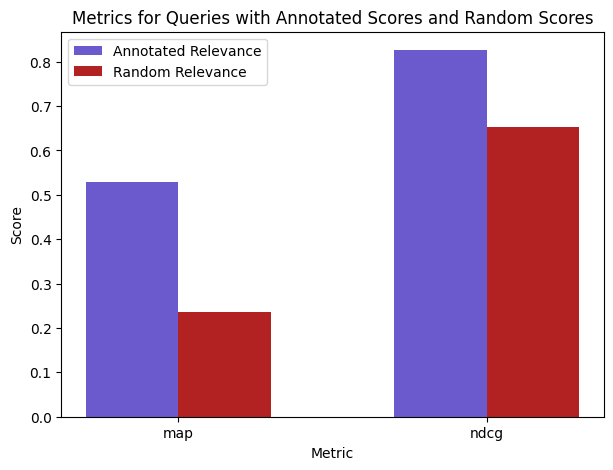

In [34]:
# bm25score = {'map': 0.1069047619047619, 'ndcg': 0.14339706949580763}
# l2rscore = {'map': 0.060444444444444446, 'ndcg': 0.14872699684474425}
# hw3score ={'map': 0.07080952380952381, 'ndcg': 0.16391514982481495}
import matplotlib.pyplot as plt
annotatedScore = {'map': 0.5283412698412698, 'ndcg': 0.8262994493378797}
randomscore = {'map': 0.23620238095238094, 'ndcg': 0.6536526819387334}
categories = list(randomscore.keys())
values1 = list(annotatedScore.values())
values2 = list(randomscore.values())

#increase figsize
# Define the width of the bars
bar_width = 0.3

# Create a figure and axis
fig, ax = plt.subplots()

fig.set_size_inches(7, 5)

# Set the positions for the bars
x = range(len(categories))
# y axis range below 0 to -.01

# Create the bars for data1
bars1 = plt.bar(x, values1, width=bar_width, label='Annotated Relevance', color='slateblue')

# Create the bars for data2, shifted to the right
x_shifted = [pos + bar_width for pos in x]
bars2 = plt.bar(x_shifted, values2, width=bar_width, label='Random Relevance', color='firebrick')
plt.xticks([pos + bar_width / 2 for pos in x], categories)
plt.legend(loc='upper left')

plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('Metrics for Queries with Annotated Scores and Random Scores')
plt.show()